In [1]:
import sev_filters_opt
from utils import gen_data_sev_H

from multiprocessing import Pool, cpu_count
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def test(X, Y, Sn, S, Hs, Cy, Cy_samp, args):
    err_H = np.zeros((len(funcs), 2))
    err_S = np.zeros((len(funcs), 2))

    norm_h = (Hs**2).sum((1,2))
    norm_A = N*(N-1)
    import warnings
    warnings.filterwarnings('ignore')

    for i, f in enumerate(funcs):
        for j, cy_use in enumerate(["real", "samp"]):

            if cy_use == "real":
                Cy_exp = Cy#.mean(0) # Depending on the option
            elif cy_use == "samp":
                Cy_exp = Cy_samp#.mean(0)
            else:
                raise NotImplementedError("Choose either real or samp covariance")

            if f in args[cy_use]:
                params = args[cy_use][f]
            else:
                params = []
            
            iter, H_est, S_est = getattr(sev_filters_opt, f)(X, Y, Sn, Cy_exp, params)

            err_H[i,j] = (((Hs - H_est)**2).sum((1,2)) / norm_h).mean()

            err_S[i,j] = ((S - S_est)**2).sum() / norm_A
            #print(f"Function {f} took {iter} iterations on covariance {cy_use}")
        
    return err_H, err_S

In [3]:
def objective(args, p_n, M, T):

    err_H = np.zeros((n_graphs, len(funcs), 2))
    err_S = np.zeros((n_graphs, len(funcs), 2))

    with Pool(processes = n_procs) as pool:

        results = []

        for i in range(n_graphs):

            X, Y, Cy, Cy_samp, Hs, S, Sn = gen_data_sev_H(N, M, T, p_er, p_n, eps, K)

            res = pool.apply_async(test, args=[X, Y, Sn, S, Hs, Cy, Cy_samp, args])
            results.append(res)

        for i in range(n_graphs):

            err_H[i,:,:], err_S[i,:,:] = results[i].get()

    dict_res = {}
    for i, cy_use in enumerate(["real", "samp"]):
        if verbose:
            print(f"Covariance: {cy_use}")
            for j, f in enumerate(funcs):
                print(f"Function: {f}")
                print(f"ErrH: {err_H[:,j,i]}")

        dict_res[cy_use] = {
            'med_H': np.median(err_H, 0)[:,i],
            'std_H': np.std(err_H, 0)[:,i],
            'mean_H': np.mean(err_H, 0)[:,i],
            'mean_S': np.mean(err_S, 0)[:,i],
            'med_S': np.median(err_S, 0)[:,i],
            'std_S': np.std(err_S, 0)[:,i]
        }
    return dict_res

In [4]:
n_graphs = 32

T_default = 5
N = 20
K = 4
p_er = 0.3

noise = [0., 0.01, 0.02, 0.03, 0.04, 0.05]
samples = [10, 20, 40, 100]
Ts = [1,2,5,10]

n_procs = min(cpu_count(), n_graphs)

p_n_default = 0.02 # Default values
M_default = 15
#cy_use = "real"

eps = 0.1
lambd = 1
delta = 1
delta_samp = 0.1
gamma = 0.01
beta = 0.001
inc_gamma = 1.3
max_iters = 10

funcs = ['estHs_unpertS', 'estHs_denS', 'estHs_iter', 'estHs_iter_rew']
verbose = False

# Alternative
args_H = {
    'real': {
        'estHs_denS': [1, 0.1], #[gamma, delta],
        'estHs_iter': [0.1, 0.1, 1, 1.1], #[lambd, gamma, delta, inc_gamma],
        'estHs_iter_rew': [0.1, 0.1, 1, 0.0001, 1.1] #[lambd, gamma, delta, beta, inc_gamma]
    }, 
    'samp': {
        'estHs_denS': [0.1, 1], #[gamma, delta_samp],
        'estHs_iter': [0.1, 0.001, 0.0001, 1.1], #[lambd, gamma, delta_samp, inc_gamma],
        'estHs_iter_rew': [1, 0.01, 0.01, 0.0001, 1.1] #[lambd, gamma, delta_samp, beta, inc_gamma]
    }
}

# Noise experiment

In [5]:
results_noise = {}
for n in noise:
    print(f"Starting {n}", flush=True)
    results_noise[n] = objective(args_H, n, M_default, T_default)

Starting 0.0
Starting 0.01
Starting 0.02
Starting 0.03
Starting 0.04
Starting 0.05


Text(0.5, 0, 'Noise power')

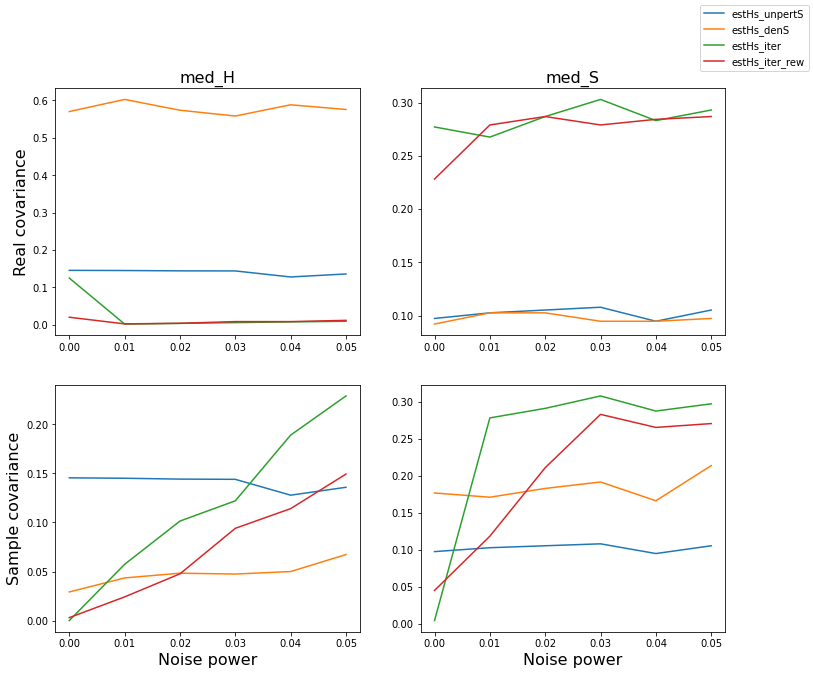

In [6]:
fig, ax = plt.subplots(2,2,figsize=(12,10))
param_0 = 'med_H'
param_1 = 'med_S'
for i, f in enumerate(funcs):
    ax[0,0].plot(noise, [r['real'][param_0][i] for r in results_noise.values()])
    ax[0,1].plot(noise, [r['real'][param_1][i] for r in results_noise.values()])
    ax[1,0].plot(noise, [r['samp'][param_0][i] for r in results_noise.values()])
    ax[1,1].plot(noise, [r['samp'][param_1][i] for r in results_noise.values()])
fig.legend(funcs)
ax[0,0].set_title(param_0, fontsize=16)
ax[0,1].set_title(param_1, fontsize=16)
ax[0,0].set_ylabel("Real covariance", fontsize=16)
ax[1,0].set_ylabel("Sample covariance", fontsize=16)
ax[1,0].set_xlabel("Noise power", fontsize=16)
ax[1,1].set_xlabel("Noise power", fontsize=16)

Text(0.5, 0, 'Noise power')

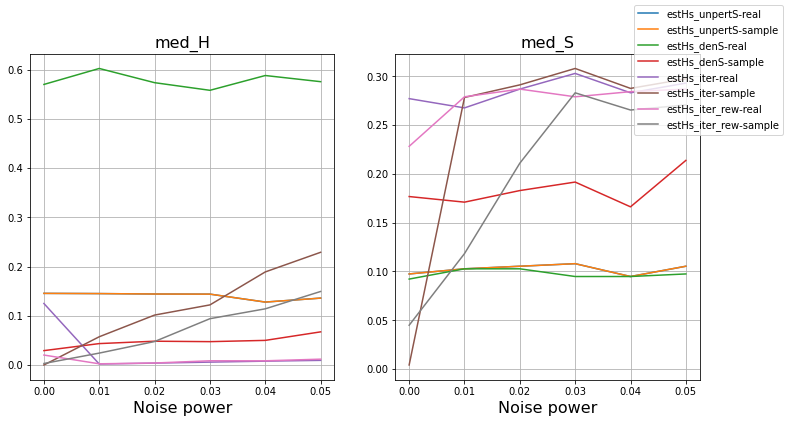

In [7]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
param_0 = 'med_H'
param_1 = 'med_S'
for i, f in enumerate(funcs):
    ax[0].plot(noise, [r['real'][param_0][i] for r in results_noise.values()], label=f"{f}-real")
    ax[1].plot(noise, [r['real'][param_1][i] for r in results_noise.values()])
    ax[0].plot(noise, [r['samp'][param_0][i] for r in results_noise.values()], label=f"{f}-sample")
    ax[1].plot(noise, [r['samp'][param_1][i] for r in results_noise.values()])
fig.legend()
ax[0].set_title(param_0, fontsize=16)
ax[1].set_title(param_1, fontsize=16)
ax[0].grid()
ax[1].grid()
ax[0].set_xlabel("Noise power", fontsize=16)
ax[1].set_xlabel("Noise power", fontsize=16)

# Samples experiment

In [8]:
results_samples = {}
for s in samples:
    print(f"Starting {s}", flush=True)
    results_samples[s] = objective(args_H, p_n_default, s, T_default)

Starting 10
Starting 20
Starting 40
Starting 100


Text(0.5, 0, 'Number of samples')

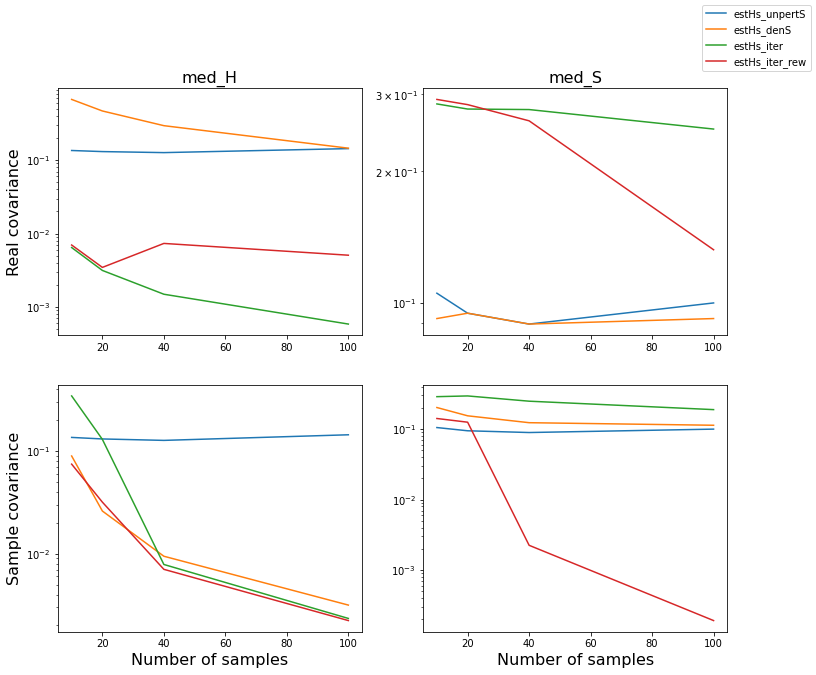

In [9]:
fig, ax = plt.subplots(2,2,figsize=(12,10))
param_0 = 'med_H'
param_1 = 'med_S'
for i, f in enumerate(funcs):
    ax[0,0].semilogy(samples, [r['real'][param_0][i] for r in results_samples.values()])
    ax[0,1].semilogy(samples, [r['real'][param_1][i] for r in results_samples.values()])
    ax[1,0].semilogy(samples, [r['samp'][param_0][i] for r in results_samples.values()])
    ax[1,1].semilogy(samples, [r['samp'][param_1][i] for r in results_samples.values()])
fig.legend(funcs)
ax[0,0].set_title(param_0, fontsize=16)
ax[0,1].set_title(param_1, fontsize=16)
ax[0,0].set_ylabel("Real covariance", fontsize=16)
ax[1,0].set_ylabel("Sample covariance", fontsize=16)
ax[1,0].set_xlabel("Number of samples", fontsize=16)
ax[1,1].set_xlabel("Number of samples", fontsize=16)

Text(0.5, 0, 'Number of samples')

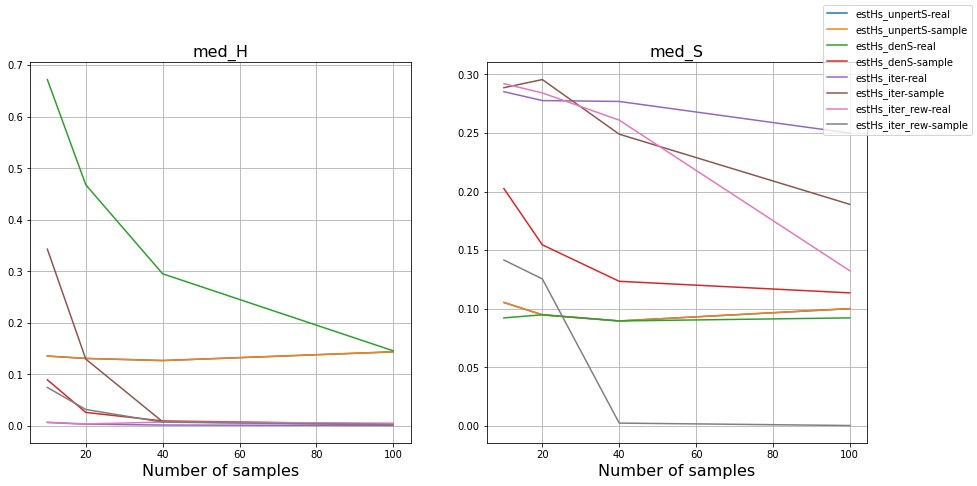

In [10]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
param_0 = 'med_H'
param_1 = 'med_S'
for i, f in enumerate(funcs):
    ax[0].plot(samples, [r['real'][param_0][i] for r in results_samples.values()], label=f"{f}-real")
    ax[1].plot(samples, [r['real'][param_1][i] for r in results_samples.values()])
    ax[0].plot(samples, [r['samp'][param_0][i] for r in results_samples.values()], label=f"{f}-sample")
    ax[1].plot(samples, [r['samp'][param_1][i] for r in results_samples.values()])
fig.legend()
ax[0].grid()
ax[1].grid()
ax[0].set_title(param_0, fontsize=16)
ax[1].set_title(param_1, fontsize=16)
ax[0].set_xlabel("Number of samples", fontsize=16)
ax[1].set_xlabel("Number of samples", fontsize=16)

# Num Filters experiment

In [11]:
results_filters = {}
for t in Ts:
    print(f"Starting {t} filters", flush=True)
    results_filters[t] = objective(args_H, p_n_default, M_default, t)

Starting 1 filters
Starting 2 filters
Starting 5 filters
Starting 10 filters


Text(0.5, 0, 'Number of filters')

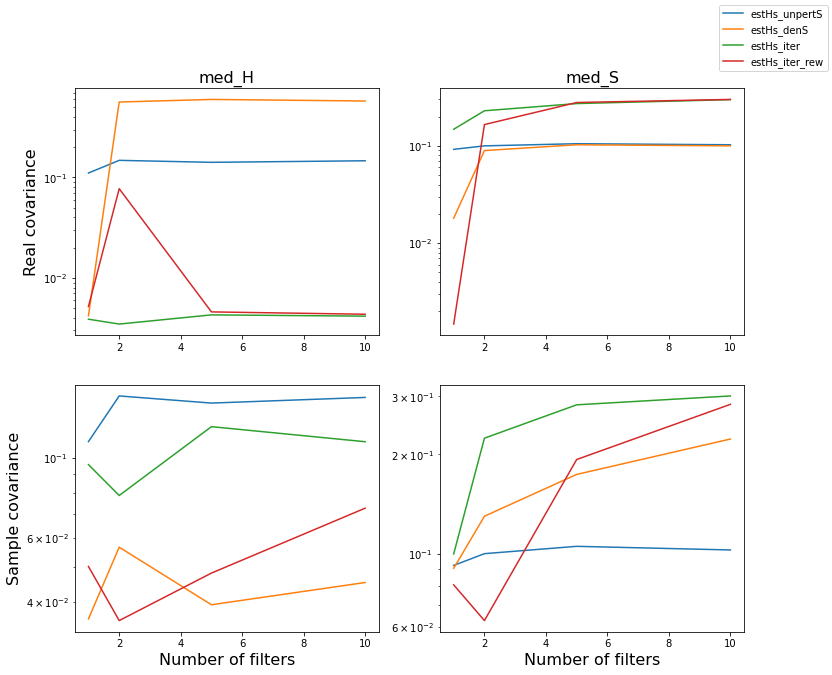

In [12]:
fig, ax = plt.subplots(2,2,figsize=(12,10))
param_0 = 'med_H'
param_1 = 'med_S'
for i, f in enumerate(funcs):
    ax[0,0].semilogy(Ts, [r['real'][param_0][i] for r in results_filters.values()])
    ax[0,1].semilogy(Ts, [r['real'][param_1][i] for r in results_filters.values()])
    ax[1,0].semilogy(Ts, [r['samp'][param_0][i] for r in results_filters.values()])
    ax[1,1].semilogy(Ts, [r['samp'][param_1][i] for r in results_filters.values()])
fig.legend(funcs)
ax[0,0].set_title(param_0, fontsize=16)
ax[0,1].set_title(param_1, fontsize=16)
ax[0,0].set_ylabel("Real covariance", fontsize=16)
ax[1,0].set_ylabel("Sample covariance", fontsize=16)
ax[1,0].set_xlabel("Number of filters", fontsize=16)
ax[1,1].set_xlabel("Number of filters", fontsize=16)

Text(0.5, 0, 'Number of filters')

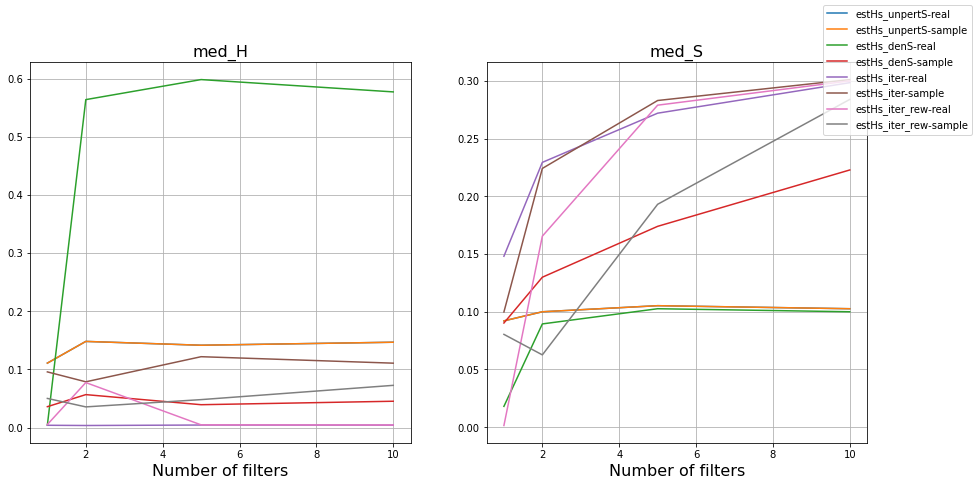

In [13]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
param_0 = 'med_H'
param_1 = 'med_S'
for i, f in enumerate(funcs):
    ax[0].plot(Ts, [r['real'][param_0][i] for r in results_filters.values()], label=f"{f}-real")
    ax[1].plot(Ts, [r['real'][param_1][i] for r in results_filters.values()])
    ax[0].plot(Ts, [r['samp'][param_0][i] for r in results_filters.values()], label=f"{f}-sample")
    ax[1].plot(Ts, [r['samp'][param_1][i] for r in results_filters.values()])
fig.legend()
ax[0].grid()
ax[1].grid()
ax[0].set_title(param_0, fontsize=16)
ax[1].set_title(param_1, fontsize=16)
ax[0].set_xlabel("Number of filters", fontsize=16)
ax[1].set_xlabel("Number of filters", fontsize=16)